In [570]:
library(reshape2)
library(dplyr)
library(igraph)
library(forcats)

## Plotting
library(ggplot2)
theme_set(theme_gray())
library(cowplot)
# library(rgl)
library(RColorBrewer)
library(pheatmap)
library(UpSetR)
library(VennDiagram)
library(xtable)
library(Rtsne)
# library(dendextend)
library(repr)
options(repr.plot.width=8, repr.plot.height=4)

library(limma)
library(sva)

## Custom
source("../functions.R")

## Import data

In [5]:
## Metadata
METADATA_RPATH <- "data/GSE67684/processed/metadata/full_metadata.tsv"
metadata_df <- read.table(METADATA_RPATH, sep = "\t")
BATCH_RPATH <- "data/GSE67684/processed/metadata/metadata-batch.tsv"
LABEL_RPATH <- "data/GSE67684/processed/metadata/metadata-label_mrd_subtype.tsv"
yeoh_batch <- read.table(BATCH_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label <- read.table(LABEL_RPATH, sep = "\t", header = T, row.names = 1)

## Subset of original data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
data <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


### Commonly used globals

In [6]:
Y <- metadata_df[colnames(data),]
Y_annot <- Y[,c("batch_info", "label")] # heatmap annot
# Y_all <- all_metadata[colnames(data_all),]

pid_remission <- rownames(Y)[Y$label == 0]

# List subtypes
all_subtypes <- levels(metadata_df$subtype)
subtypes <- setdiff(all_subtypes, c("Hypodiploid", "Normal"))

### Plot: PCA

In [342]:
# Plots batches in different colours and classes in different symbols
plot_pca_2d <- function(df1, metadata_df, pc_labels = NULL) {
  # Obtaining batch and class annotations
  batch_factor <- as.factor(metadata_df[colnames(df1),"batch_info"])
  class_factor <- metadata_df[colnames(df1),"class_info"]
  print(head(batch_factor))
  print(head(class_factor))
  
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(df1))
    pca_df <- data.frame(pca_obj$x[,1:4])
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- data.frame(df1)
  }
  
  pc1_pc2 <- ggplot(pca_df, aes(x = PC1, y = PC2, fill = batch_factor,
                                pch = class_factor)) +
    geom_point(size = 3, show.legend = F) +
    labs(x = pc_labels[1], y = pc_labels[2]) +
    scale_shape_manual(values = 21:23) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5)
  # theme(plot.title = element_text(hjust = 0.5))

  #   pc1_pc3 <- ggplot(pca_df, aes(x = PC1, y = PC3, col = batch_factor,
  #                                 pch = class_factor)) +
  #     geom_point(size = 3, show.legend = F) +
  #     labs(x = pc_labels[1], y = pc_labels[3]) +
  #     geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
  #     geom_hline(yintercept = 0, color = "black", alpha = 0.5)
  
  #   pca_plot <- plot_grid(pc1_pc2, pc1_pc3)
  
  return(pc1_pc2)
}


In [459]:
#' @param response_df dataframe with samples x features
#' @param normal_df dataframe with samples x features
# D0 centroid used to define D0-Normal vector
calcERM <- function(response_df, normal_df) {
  # Split response df into D0 and D8 df
  n <- nrow(response_df)/2
  d0_df <- response_df[1:n,]
  d8_df <- response_df[-(1:n),]
  stopifnot(substring(rownames(d8_df),1,4) == substring(rownames(d0_df),1,4))
  
  # Calculate centroids
  leuk_centroid <- apply(d0_df, 2, median)
  normal_centroid <- apply(normal_df, 2, median)
  
  # Calculate leuk-normal unit vector
  leuk_normal <- normal_centroid - leuk_centroid
  unit_leuk_normal <- leuk_normal/calcL2Norm(leuk_normal)
  
  # Assume that patients from top rows match correspondingly with bottom rows
  # Calculate vector by: D8-D0
  d0_d8_hstack <- d8_df - d0_df
  # Multiplication of erm_factor is propagated through every column
  ### ERM1 ###
  erm1 <- colSums(t(d0_d8_hstack) * unit_leuk_normal)
  # Vertical stack of individual D0-Normal vectors
  d0_normal_vstack <- normal_centroid - t(d0_df)
  ### D0-Normal projection ###
  d0_normal_proj <- colSums(d0_normal_vstack * unit_leuk_normal)
  ### ERM1 Ratio ###
  ## ERM1 / projection of D0-N on L-N
  erm1_ratio1 <- erm1/d0_normal_proj
  
  d8_normal_vstack <- normal_centroid - t(d8_df)
  ### D8-Normal projection ###
  d8_normal_proj <- colSums(d8_normal_vstack * unit_leuk_normal)
  
  stopifnot(identical(names(erm1), names(erm1_ratio1)))
  
  # Calculate vstack of unit D0-Normal vectors
  l2norm_d0_normal <- apply(d0_normal_vstack, 2, calcL2Norm)
  unit_d0_normal_vstack <- sweep(d0_normal_vstack, 2, l2norm_d0_normal, "/")
  
  ### ERM2 ###
  ## Projection of D0-D8 on D0-N
  erm2 <- colSums(t(d0_d8_hstack) * unit_d0_normal_vstack)
  erm2_ratio <- erm2/l2norm_d0_normal
  
  stopifnot(identical(names(erm2), names(erm2_ratio)))
  
  ### ERM3 ###
  ## Along a chosen PC that represents timepoint
  PC <- 1
  # Be careful of direction of D0-N (may be negative)
  # If negative, a larger shift will lead to a smaller ERM3
  dir <- sign(median(normal_df[,PC]) - median(d0_df[,PC]))
  erm3 <- (d8_df[,PC] - d0_df[,PC]) * dir # direction is normalised
  # Divide by D0-Normal along PC
  erm3_ratio <- erm3/(median(normal_df[,PC]) - d0_df[,PC])
  
  stopifnot(identical(names(erm3), names(erm3_ratio)))
  
  ### l2norm ###
  l2norm_d0_d8 <- apply(d0_d8_hstack, 1, calcL2Norm)
  l2norm_d0 <- apply(d0_df, 1, calcL2Norm)
  l2norm_d8 <- apply(d8_df, 1, calcL2Norm)
  diff_l2norm <- l2norm_d8 - l2norm_d0
  
  ### Angle between D0-D8 and Leuk-Normal ###
  angle_d0d8_normal <- apply(
    d0_d8_hstack, 1, function(row_vec) calcAngleVectors(row_vec, leuk_normal)
  )
  
  ### Angle between D0-D8 and D0-Normal ###
  angle_d0d8_d0normal <- mapply(calcAngleVectors,
                                data.frame(t(d0_d8_hstack)),
                                data.frame(d0_normal_vstack))
  
  ### Angle between D0 and D8 ###
  angle_d0_d8 <- mapply(calcAngleVectors,
                        data.frame(t(d0_df)), data.frame(t(d8_df)))
  
  ### Angle between D0 and normal ###
  angle_d0_normal <- apply(
    d0_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between D8 and Normal ###
  angle_d8_normal <- apply(
    d8_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between N-D0 and N-D8 ###
  # Equivalent to angle between D0-N and D8-N
  angle_nd0_nd8 <- mapply(calcAngleVectors,
                          data.frame(d0_normal_vstack),
                          data.frame(d8_normal_vstack))
  
  ### Angle between N-centroid(D0) N-D8 ###
  # Equivalent to angle between centroid(D0)-N and D8-N
  angle_nl_nd8 <- sapply(data.frame(d8_normal_vstack),
                         function(x, y) calcAngleVectors(x, y),
                         leuk_normal)
  
  ### L2-norm between D8 and Normal ###
  l2norm_d8_normal <- apply(d8_normal_vstack, 2, calcL2Norm)
  
  ### L2-norm ratios
  l2norm_ratio1 <- l2norm_d0_d8/l2norm_d0_normal
  l2norm_ratio2 <- l2norm_d0_d8/l2norm_d8_normal
  l2norm_diff <- l2norm_d0_normal - l2norm_d8_normal
  l2norm_diff_ratio <- l2norm_diff/l2norm_d0_d8
  
  ### Ratios
  erm1_ratio2 <- erm1/abs(d8_normal_proj)
  erm1_ratio3 <- erm1/l2norm_d0_d8
  
  ### Concatenate all features ###
  features_df <- data.frame(
    erm1, erm1_ratio1, erm2, erm2_ratio, erm3, erm3_ratio,
    d0_normal_proj, d8_normal_proj, l2norm_d0_d8,
    diff_l2norm, angle_d0_d8, angle_nd0_nd8, angle_nl_nd8,
    angle_d0d8_normal, angle_d0d8_d0normal,
    angle_d0_normal, angle_d8_normal,
    l2norm_d0_normal, l2norm_d8_normal,
    l2norm_ratio1, l2norm_ratio2,
    l2norm_diff, l2norm_diff_ratio,
    erm1_ratio2, erm1_ratio3
  )
  return(features_df)
}

plotPrediction <- function(results, metadata_df, yeoh_label) {
  y <- as.factor(metadata_df[rownames(results),"label"])
#   features1 <- results[,c("erm1", "l2norm_d0_d8"), drop=F] # OPTION
  features1 <- results[,c("erm1_ratio2", "l2norm_ratio2"), drop=F]
  features2 <- results[, "angle_d0d8_normal", drop=F]
#   reverse_features2 <- -features2 # OPTION 2
  
  # MRD (D33)
  pid_idx <- substr(rownames(results), 1, 4)
  d33_mrd <- yeoh_label[pid_idx, "d33_mrd"]
  mrd_rank <- rank(d33_mrd, na.last = T, ties.method="min")
  mrd_percent <- (mrd_rank-1)/sum(!is.na(d33_mrd))
  mrd_percent[is.na(d33_mrd)] <- NA
  
  # Two different ways of rankings
  features_rankdesc <- apply(-features1, 2, rank, ties.method="min")
  features_percentdesc <- (features_rankdesc-1)/nrow(features1)
  features_rankasc <- apply(features2, 2, rank, ties.method="min") # OPTION 1
#   features_rankasc <- apply(reverse_features2, 2, rank, ties.method="min") # OPTION 2
  features_percentasc <- (features_rankasc-1)/nrow(features2)
  features_percent <- cbind(features_percentdesc, features_percentasc)
  features_mrd_percent <- cbind(features_percent, mrd_percent)
  
  if (sum(is.na(features_percentasc), is.na(features_percentdesc)) > 0)
    warning("Features contain NA values")
  
  # Calculate p for features and avg_p
  avg_percent <- rowMeans(features_percent, na.rm = T) # DOES NOT INCLUDE MRD PERCENTILE IN CALCULATION
  avgpercent_y <- data.frame(p = avg_percent, label = y)
  percent_y <- cbind(pid = rownames(features_mrd_percent),
                     avgpercent_y, features_mrd_percent)
  long_percent_y <- melt(percent_y, id = c("pid", "label"),
                         variable.name = "feature")
  
  pid_idx <- substr(rownames(avgpercent_y), 1, 4)
  avgpercent_mrd <- cbind(avgpercent_y,
                          d33_mrd = -log10(yeoh_label[pid_idx, "d33_mrd"]))
  
  # Features and avg_p for jitter plot
  features_y <- data.frame(features1, features2, p = avg_percent, label = y)
  long_features_y <- melt(features_y, id="label", variable.name = "feature")
  
  # Calculating relative risk
  sort_avgp <- avgpercent_y[order(avgpercent_y$p),]
  sort_avgp$label <- as.numeric(as.character(sort_avgp$label))
  sort_avgp$total_le <- rank(sort_avgp$p, ties.method = "max")
  sort_avgp$total_g <- nrow(sort_avgp) - sort_avgp$total_le
  sort_avgp$relapse_le <- sapply(sort_avgp$total_le,
                                 function(i) sum(sort_avgp$label[1:i]))
  sort_avgp$relapse_g <- sum(sort_avgp$label) - sort_avgp$relapse_le
  sort_avgp <- within(sort_avgp,
                      relative_risk <-
                        (relapse_le/total_le)/(relapse_g/total_g))
  sort_avgp <- within(sort_avgp,
                      odds_ratio <-
                        (relapse_le/(total_le-relapse_le))/
                        (relapse_g/(total_g-relapse_g)))
  
  # PLOT: FEATURES
  jitter_features <- ggplot(long_features_y,
                             aes(feature, value, colour = label)) +
    geom_point(position = position_jitterdodge(), cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    facet_wrap(~feature, nrow = 1, scales = "free") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(angle = 10, vjust = 0.5))

  emp_cdf <- ggplot(avgpercent_y, aes(x = p, colour = label)) +
    stat_ecdf(show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))

  rel_risk <- ggplot(sort_avgp) +
    geom_step(aes(p, relative_risk, colour = "RR"), direction = "hv") + 
    geom_step(aes(p, odds_ratio, colour = "OR"), direction = "hv") +
    scale_color_manual("",
                       breaks = c("RR", "OR"),
                       values = c("RR" = "orange", "OR" = "steelblue3")) +
    theme(axis.title.y = element_blank())
  
  ax1 <- plot_grid(jitter_features, emp_cdf, rel_risk,
                   ncol = 3, rel_widths = c(2.5,1.2,1.3))
  
  parallel <- ggplot(long_percent_y) +
    geom_line(aes(feature, value, colour = label, group = pid),
              show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))
  
  mrd_p <- ggplot(avgpercent_mrd) +
    geom_point(aes(p, d33_mrd, colour = label), cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))
  
  ax2 <- plot_grid(parallel, mrd_p, ncol = 2, rel_widths = c(2.5,1))
  
  fig <- plot_grid(ax1, ax2, nrow = 2)
                                 
  return(fig)
#   return(list(fig))
}

In [173]:
# Prediction (Drug genes) --------------------------------------------
## Drug responsive genes
#' @param X_subtype df of patients from a specific subtype (D0 followed by D8)
getLocalGenes <- function(X_subtype, pid_remission,
                          alpha = 0.05, EXPR = 6, N = 50, LOGFC = 1) {
  pid_idx <- intersect(pid_remission, colnames(X_subtype))
  X_subtype_remission <- X_subtype[,pid_idx, drop = F]
  n_pairs <- ncol(X_subtype_remission)/2
  
  # P-value
  pvalue <- calc_ttest(X_subtype_remission, n_pairs, is_paired = T) # nan values!

  # # Q-value
  # calc_qvalue <- function(p) length(p)*p/rank(p)
  # qvalue <- calc_qvalue(pvalue) # FDR threshold
  # hist(qvalue, breaks =20)
  
  # Median paired log-FC
  paired_logfc <- X_subtype_remission[,-(1:n_pairs)] -
    X_subtype_remission[,1:n_pairs] # D8 - D0
  median_logfc <- apply(paired_logfc, 1, median)
  print(sprintf("No. of NaN values in log-fc = %d",
                 sum(is.na(median_logfc))))
  median_logfc1 <- median_logfc[!is.na(median_logfc)]
  
  d0_mu <- rowMeans(X_subtype_remission[,1:n_pairs])
  d8_mu <- rowMeans(X_subtype_remission[,-(1:n_pairs)])
  
  # Filter genes that do not exceed a threshold in
  # expression in any condition
  selected_median_logfc <- median_logfc1[d0_mu > EXPR | d8_mu > EXPR]
  print(sprintf("No. of probesets excluded by expr threshold = %d",
                length(median_logfc1) - length(selected_median_logfc)))
  # feat_top_median_logfc <- names(head(sort(selected_median_logfc), N))
  
  # # Custom t-statistic
  # deviation_median <- sweep(paired_logfc, 1, median_logfc, "-")
  # median_abs_dev <- apply(abs(deviation_median), 1, median)
  # test_stat <- median_logfc/(median_abs_dev/n_pairs^0.5)
  # pvalue <- pt(abs(test_stat)*-1, n_pairs-1)
  # hist(pvalue, breaks = 30)
  # feat_selected_p <- names(head(sort(pvalue), N))

  feat_p <- names(pvalue)[pvalue < alpha & !is.na(pvalue)]
  # At least one of the means have to be > EXPR
  feat_log2fc <- names(selected_median_logfc)[abs(selected_median_logfc) > LOGFC]
  feat <- intersect(feat_p, feat_log2fc)
  
  print(sprintf("No. of features (p-value) = %d", length(feat_p)))
  print(sprintf("No. of features (log2-fc) = %d", length(feat_log2fc)))
  print(sprintf("No. of features (intersect) = %d", length(feat)))
  
  return(feat)
}

### Ensemble PCA
- For each batch: Perform PCA on batch x and project rest of batches into PC space

In [337]:
#' @param X dataframe with features x samples that has been
#' filtered for drug response genes
get_bara <- function(batch_id, X, Y) {
  #' PCA space is defined using a single batch and the rest of the batches are projected in
  #' @param X1, X2 dataframe with features x samples
  helper_pca <- function(X1, X2, metadata_df, n_pc = 10) {
    pca_obj <- prcomp(t(X1))
    X1_pca <- data.frame(pca_obj$x[,1:n_pc])
    X2_pca <- data.frame(predict(pca_obj, t(X2))[,1:n_pc])
    X_pca <- rbind(X1_pca, X2_pca)

    # Reorder patients according to pid and then timepoint
    Y_pca <- metadata_df[rownames(X_pca)[order(rownames(X_pca))],]
    Y_pca <- Y_pca[order(Y_pca$class_info),]
    X_pca <- X_pca[rownames(Y_pca),]

    return(X_pca)
  }
  
  pid_batch <- rownames(Y)[Y$batch_info == batch_id]
  pid_others <- rownames(Y)[Y$batch_info != batch_id]
  helper_pca(X[, pid_batch], X[, pid_others], Y)
}

In [338]:
#' @param X_allpca dataframe of entire dataset with samples x principal components
predict_subtype <- function(X_allpca, Y, subtype, n_pc = 10, cex = 3) {
  # Subset specific subtype
  Y <- Y[rownames(X_allpca),]
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  X1 <- X_allpca[c(pid_subtype, pid_normal),]
  
  # PCA
  pca_obj <- prcomp(X1)
  X1_pca <- data.frame(pca_obj$x[,1:n_pc])
  n <- nrow(X1_pca)
  d0_pca <- X1_pca[1:((n-3)/2),]
  d8_pca <- X1_pca[((n-1)/2):(n-3),]
  norm_pca <- X1_pca[(n-2):n,]
  
  print(head(rownames(d0_pca)))
  print(head(rownames(d8_pca)))
  print(head(rownames(norm_pca)))
  stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))
  
  # Axis labels
  eigenvalues <- (pca_obj$sdev)^2
  var_pc <- eigenvalues[1:n_pc]/sum(eigenvalues)
  pc_labels <- sprintf("PC%d (%.2f%%)", 1:n_pc, var_pc*100)

  # Metadata
  batch_factor <- as.factor(Y[rownames(X1_pca), "batch_info"])
  class_factor <- Y[rownames(X1_pca), "class_info"]

  # PCA plot
  pc1_pc2 <- ggplot(X1_pca, aes(x = PC1, y = PC2, fill = batch_factor,
                               pch = class_factor)) +
    geom_point(size = 3, show.legend = T) +
    labs(x = pc_labels[1], y = pc_labels[2]) +
    scale_shape_manual(values = 21:23) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5)
  
  # Vectors plot
  subtype_pca <- cbind(d0_pca, d8_pca)
  colnames(subtype_pca) <- c(
    paste(colnames(subtype_pca)[1:n_pc], "A", sep = "_"),
    paste(colnames(subtype_pca)[(n_pc+1):(n_pc*2)], "B", sep = "_")
  )
  print(colnames(subtype_pca))

  # Obtaining batch and class annotations
  label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
  batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])
  print(label)

  vectors_plot <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = T) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
  #     geom_text(aes(x = PC1_A, y = PC3_A,
  #                   label = rownames(subtype_pca)),
  #               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 17) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])

  # Prediction
  response <- rbind(d0_pca, d8_pca)
  results <- calcERM(response, norm_pca)
  #   print("Results!")
  #   print(head(results))

  label <- as.factor(metadata_df[rownames(results), "label"])
  prediction_plot <- plotPrediction(results, metadata_df, yeoh_label)
  
  # Jitter plot (subtype)
  metadata_df$label <- as.factor(metadata_df$label)
  metadata_df$batch_info <- as.factor(metadata_df$batch_info)
  
  subtype_pca_annot <- cbind(metadata_df[rownames(X1_pca),
                                         c("batch_info", "class_info", "label")], X1_pca)
  long_subtype_pca_annot <- melt(subtype_pca_annot,
                                 id.vars = c("batch_info", "class_info", "label"),
                                 variable.name = "PC")
  print(head(long_subtype_pca_annot))
  
  ax_batch <- ggplot(long_subtype_pca_annot,
                aes(x = PC, y = value,
                    shape = class_info,
                    fill = batch_info,
                    group = batch_info)) +
    geom_point(cex = cex, show.legend = F,
               position = position_jitterdodge(jitter.height=0)) +
    scale_shape_manual(values = 21:23)

  ax_timepoint <- ggplot(long_subtype_pca_annot,
                aes(x = PC, y = value,
                    shape = class_info,
                    fill = label)) +
    geom_point(cex = cex, show.legend = F,
               position = position_jitterdodge(jitter.height=0)) +
    scale_shape_manual(values = 21:23) +
    scale_fill_manual(values = c("darkolivegreen3", "tomato3"))
  
  jitter_plot <- plot_grid(ax_batch, ax_timepoint, ncol = 2)
  
  return(list(vectors_plot, jitter_plot, prediction_plot))
}

In [339]:
for (subtype in subtypes) {
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  data_subtype <- data[,pid_subtype]
  drug_genes <- getLocalGenes(data_subtype, pid_remission)
  X_fltr <- data[drug_genes,] # Signal enrichment: Drug response genes

  batches <- setdiff(1:10, 5)
  list_telaml1_pca <- lapply(batches, get_bara, X_fltr, Y)
  telaml1_allpca <- do.call(cbind, list_telaml1_pca)

  list_fig <- predict_subtype(telaml1_allpca, Y, subtype)
#   wpath1 <- sprintf("~/Dropbox/temp/vectors-drug_ensemble_%s.pdf", subtype)
  wpath2 <- sprintf("~/Dropbox/temp/jitter-drug_ensemble_%s.pdf", subtype)
#   wpath3 <- sprintf("~/Dropbox/temp/prediction-drug_ensemble_%s.pdf", subtype)
#   ggsave(wpath1, list_fig[[1]], width = 10, height = 5)
  ggsave(wpath2, list_fig[[2]], width = 10, height = 5)
#   ggsave(wpath3, list_fig[[3]], width = 10, height = 5)
}

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of features (intersect) = 21"
[1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0"
[1] "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8" "P134_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
 [1] 1 1 1 2 2 2 2 1 1 2
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_normal_proj"      "d8_normal_proj"      "l2norm_d0_d8"       
[10] "diff_l2norm"         "angle_d0_d8"         "angle_nd0_nd8"      
[13] "angle_nl_nd8"        "angle_d0d8_normal"   "angle_d0d8_d0normal"
[16] "angle_d0_normal"     "angle_d8_normal"     "l2norm_d0_normal

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

  batch_info class_info label  PC     value
1          2         D0     0 PC1 -33.65285
2          3         D0     0 PC1 -32.16397
3          4         D0     0 PC1 -12.42776
4          4         D0     1 PC1 -20.08062
5          1         D0     1 PC1 -25.20132
6          6         D0     1 PC1 -24.83397
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of features (intersect) = 239"
[1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0"
[1] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
[1] 1 1 1 2 2 1 1
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"               

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

  batch_info class_info label  PC      value
1          2         D0     0 PC1  -57.14639
2          3         D0     0 PC1 -119.33114
3          1         D0     0 PC1 -126.49998
4          9         D0     1 PC1   21.92405
5          9         D0     1 PC1  -27.94551
6          8         D0     0 PC1  -70.64311
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of features (intersect) = 284"
[1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0"
[1] "P037_D8" "P038_D8" "P039_D8" "P040_D8" "P041_D8" "P042_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1
 [1] "erm1"                "erm1_ratio1"        

Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

  batch_info class_info label  PC      value
1          1         D0     0 PC1 -196.68949
2          2         D0     1 PC1  -62.07391
3          3         D0     0 PC1   44.88926
4          3         D0     0 PC1  -15.46104
5          3         D0     0 PC1  -53.03547
6          4         D0     0 PC1 -176.08783
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"
[1] "No. of features (p-value) = 614"
[1] "No. of features (log2-fc) = 1031"
[1] "No. of features (intersect) = 262"
[1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0"
[1] "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
[1] 1 2 2 2 2 1 2 1
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"     

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

  batch_info class_info label  PC     value
1          4         D0     0 PC1 -54.79023
2          6         D0     1 PC1 -74.36469
3          9         D0     1 PC1 -23.86576
4          9         D0     1 PC1 -58.00132
5          9         D0     1 PC1 -22.18177
6          7         D0     0 PC1 -55.91543
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 822"
[1] "No. of features (p-value) = 3081"
[1] "No. of features (log2-fc) = 448"
[1] "No. of features (intersect) = 448"
[1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0"
[1] "P059_D8" "P060_D8" "P061_D8" "P062_D8" "P063_D8" "P064_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
 [1] 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 2 1 2 2
[39] 1 2 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

  batch_info class_info label  PC      value
1          3         D0     0 PC1  -95.28371
2          4         D0     0 PC1  -55.25340
3          4         D0     0 PC1 -141.60988
4          4         D0     1 PC1  -58.57127
5          1         D0     0 PC1  -89.71764
6          1         D0     0 PC1 -100.90779
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1198"
[1] "No. of features (p-value) = 593"
[1] "No. of features (log2-fc) = 234"
[1] "No. of features (intersect) = 80"
[1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0"
[1] "P001_D8" "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
 [1] 1 1 1 2 1 1 1 1 1 1 1 2 1
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

  batch_info class_info label  PC      value
1          3         D0     0 PC1 -29.752014
2          2         D0     0 PC1  10.158229
3          2         D0     0 PC1  -6.632381
4          2         D0     1 PC1 -11.146247
5          3         D0     0 PC1 -62.110253
6          1         D0     0 PC1   3.799005
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 743"
[1] "No. of features (p-value) = 2818"
[1] "No. of features (log2-fc) = 521"
[1] "No. of features (intersect) = 519"
[1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0"
[1] "P013_D8" "P014_D8" "P015_D8" "P016_D8" "P017_D8" "P018_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
 [1] 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1
[39] 1
 [1] "erm1"                "erm1_ratio1" 

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

  batch_info class_info label  PC      value
1          3         D0     0 PC1 -177.83944
2          4         D0     0 PC1   60.17163
3          4         D0     0 PC1   67.11763
4          4         D0     0 PC1 -121.94470
5          4         D0     0 PC1   38.91236
6          1         D0     0 PC1 -123.76977


[1] 3 2 2 2 3 1
Levels: 1 2 3 4 6 7 8 9 10
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N


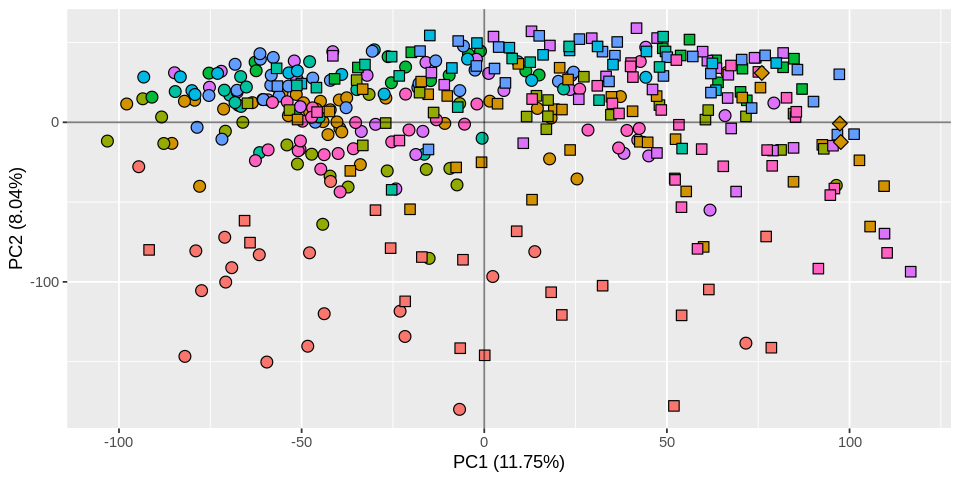

In [272]:
raw_pca <- plot_pca_2d(data, metadata_df)

### Define PCA with single batch and project rest of batches

In [320]:
#' Plot vectors and MILE data (two scatter plots)
#' PCA space is defined using a single batch and the rest of the batches are projected in
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
plot_bara <- function(X1, X2, metadata_df, subtype, n_pc = 10,
                        cex = 3, pc_labels = NULL, main = NULL) {
  pca_obj <- prcomp(t(X1))
  X1_pca <- data.frame(pca_obj$x[,1:n_pc])
  X2_pca <- data.frame(predict(pca_obj, t(X2))[,1:n_pc])
  X_pca <- rbind(X1_pca, X2_pca)
  
  # Axis labels
  eigenvalues <- (pca_obj$sdev)^2
  var_pc <- eigenvalues[1:n_pc]/sum(eigenvalues)
  pc_labels <- sprintf("PC%d (%.2f%%)", 1:n_pc, var_pc*100)
  
  # Metadata
  batch_factor <- as.factor(metadata_df[rownames(X_pca),"batch_info"])
  class_factor <- metadata_df[rownames(X_pca),"class_info"]
  
  pc1_pc2 <- ggplot(X_pca, aes(x = PC1, y = PC2, fill = batch_factor,
                               pch = class_factor)) +
    geom_point(size = 3, show.legend = F) +
    labs(x = pc_labels[1], y = pc_labels[2]) +
    scale_shape_manual(values = 21:23) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5)
  
  # Jitter plot (batch)
  metadata_df$batch_info <- as.factor(metadata_df$batch_info)
  X_pca_annot <- cbind(metadata_df[rownames(X_pca), c("batch_info", "class_info")], X_pca)
  long_pca_annot <- melt(X_pca_annot,
                         id.vars = c("batch_info", "class_info"),
                         variable.name = "PC")
  print(head(long_pca_annot))
  
  jitter_plot <- ggplot(long_pca_annot,
                        aes(x = PC, y = value,
                            shape = class_info,
                            fill = batch_info,
                            group = batch_info)) +
#     geom_point(cex = cex, position = position_jitter()) +
    geom_point(cex = cex,
               position = position_jitterdodge(jitter.width=.7, jitter.height=0),
               show.legend = F) +
    scale_shape_manual(values = 21:23)
  
  ## Vector plot
  # Select subset of patients
  Y_pca <- metadata_df[rownames(X_pca),] 
  idx <- rownames(Y_pca)[Y_pca$subtype ==  subtype | Y_pca$subtype ==  "Normal"]
  Y_pca <- Y_pca[idx,]
  # Reorder patients according to timepoint
  Y_pca <- Y_pca[order(Y_pca$class_info),]
  
  X_pca <- X_pca[rownames(Y_pca),]
  n <- nrow(X_pca)
  
  d0_pca <- X_pca[1:((n-3)/2),]
  d8_pca <- X_pca[((n-1)/2):(n-3),]
  norm_pca <- X_pca[(n-2):n,]
  
  print(head(rownames(d0_pca)))
  print(head(rownames(d8_pca)))
  print(head(rownames(norm_pca)))
  
  stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))

  subtype_pca <- cbind(d0_pca, d8_pca)
  
  colnames(subtype_pca) <- c(
    paste(colnames(subtype_pca)[1:n_pc], "A", sep = "_"),
    paste(colnames(subtype_pca)[(n_pc+1):(n_pc*2)], "B", sep = "_")
  )
  print(colnames(subtype_pca))  

  # Obtaining batch and class annotations
  label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
  batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])
  print(label)
  
  # Vectors plot
  vectors_plot <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = T) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC3_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 17) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  # Prediction
  response <- rbind(d0_pca, d8_pca)
  results <- calcERM(response, norm_pca)
  #   print("Results!")
  #   print(head(results))
  
  label <- as.factor(metadata_df[rownames(results), "label"])
  fig <- plotPrediction(results, metadata_df, yeoh_label)
  
  # Jitter plot (subtype)
  metadata_df$label <- as.factor(metadata_df$label)
  subtype_pca_annot <- cbind(metadata_df[rownames(X_pca), c("label", "class_info")], X_pca)
  long_subtype_pca_annot <- melt(subtype_pca_annot,
                                 id.vars = c("label", "class_info"),
                                 variable.name = "PC")
  print(head(long_subtype_pca_annot))
  
  jitter_subtype <- ggplot(long_subtype_pca_annot,
                        aes(x = PC, y = value,
                            shape = class_info,
                            fill = label,
                            group = label)) +
#     geom_point(cex = cex, position = position_jitter()) +
    geom_point(cex = cex,
               position = position_jitterdodge(jitter.width=.7, jitter.height=0),
               show.legend = F) +
    scale_shape_manual(values = 21:23) +
    scale_fill_manual(values = c("darkolivegreen3", "tomato3"))
  
  return(jitter_subtype)
}

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 743"
[1] "No. of features (p-value) = 2818"
[1] "No. of features (log2-fc) = 521"
[1] "No. of features (intersect) = 519"
  batch_info class_info  PC     value
1          8         D0 PC1 -21.26770
2          8         D0 PC1 -63.30632
3          8         D0 PC1 -75.11654
4          8         D0 PC1 -40.78741
5          8         D0 PC1 -59.63657
6          8         D0 PC1  20.44078
[1] "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P166_D0" "P013_D0"
[1] "P135_D8" "P136_D8" "P147_D8" "P156_D8" "P166_D8" "P013_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
 [1] 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1
[39] 1
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"  

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

  label class_info  PC     value
1     0         D0 PC1 -63.30632
2     1         D0 PC1 -75.11654
3     0         D0 PC1 -33.59989
4     0         D0 PC1 -44.67616
5     0         D0 PC1 -31.55998
6     0         D0 PC1 -69.18833


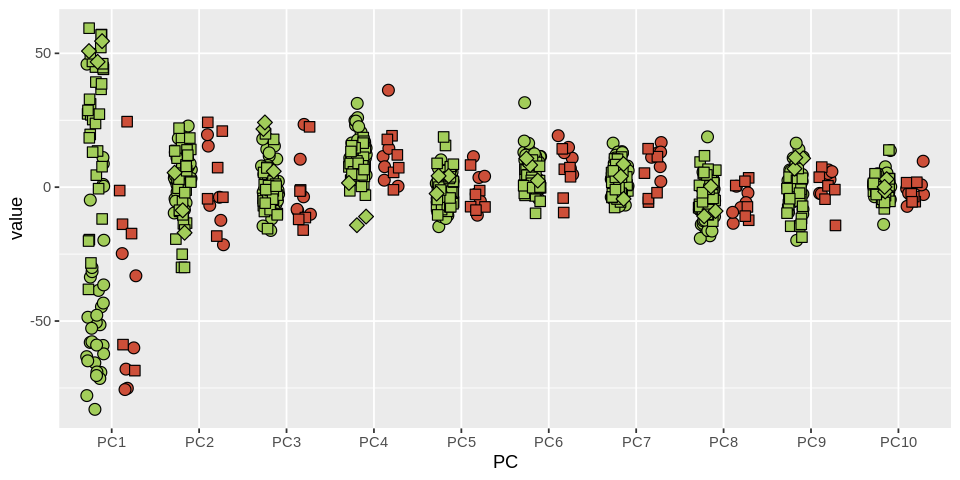

In [321]:
subtype <- "TEL-AML1"
pid_subtype <- rownames(Y)[Y$subtype == subtype]
data_subtype <- data[,pid_subtype]
drug_genes <- getLocalGenes(data_subtype, pid_remission)

BATCH <- 8
pid_batch <- rownames(Y)[Y$batch_info == BATCH]
pid_others <- rownames(Y)[Y$batch_info != BATCH]

fig <- plot_bara(data[drug_genes, pid_batch], data[drug_genes, pid_others], Y, subtype)
# wpath <- "~/Dropbox/temp/jitter-batch8_ensemble.pdf"
# ggsave(wpath, jitter_batch8, width = 10, height = 5)
fig

In [311]:
for (subtype in subtypes) {
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  data_subtype <- data[,pid_subtype]
  drug_genes <- getLocalGenes(data_subtype, pid_remission)

  BATCH <- 8
  pid_batch <- rownames(Y)[Y$batch_info == BATCH]
  pid_others <- rownames(Y)[Y$batch_info != BATCH]

  fig <- plot_bara(data[drug_genes, pid_batch], data[drug_genes, pid_others], Y, subtype)
  wpath <- sprintf("~/Dropbox/temp/vectors-batch8_drug_%s.pdf", subtype)
  ggsave(wpath, fig, width = 10, height = 5)  
}

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of features (intersect) = 21"
  batch_info class_info  PC       value
1          8         D0 PC1  -8.2363904
2          8         D0 PC1 -10.3985784
3          8         D0 PC1  -8.7330527
4          8         D0 PC1   0.6470414
5          8         D0 PC1  -7.2114081
6          8         D0 PC1   6.4157375
[1] "P175_D0" "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0"
[1] "P175_D8" "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
 [1] 1 1 1 1 2 2 2 2 1 2
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of features (intersect) = 239"
  batch_info class_info  PC      value
1          8         D0 PC1  -7.899694
2          8         D0 PC1 -24.780444
3          8         D0 PC1 -30.917633
4          8         D0 PC1 -22.763354
5          8         D0 PC1 -30.660613
6          8         D0 PC1   4.709721
[1] "P145_D0" "P161_D0" "P049_D0" "P050_D0" "P051_D0" "P102_D0"
[1] "P145_D8" "P161_D8" "P049_D8" "P050_D8" "P051_D8" "P102_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
[1] 1 1 1 1 1 2 2
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_nor

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of features (intersect) = 284"
  batch_info class_info  PC     value
1          8         D0 PC1 -25.59337
2          8         D0 PC1 -50.16934
3          8         D0 PC1 -55.75421
4          8         D0 PC1 -36.00085
5          8         D0 PC1 -60.33267
6          8         D0 PC1  19.10935
[1] "P138_D0" "P139_D0" "P140_D0" "P148_D0" "P159_D0" "P162_D0"
[1] "P138_D8" "P139_D8" "P140_D8" "P148_D8" "P159_D8" "P162_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
 [1] 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 2 1 1 1 1
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"         

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 487"
[1] "No. of features (p-value) = 614"
[1] "No. of features (log2-fc) = 1031"
[1] "No. of features (intersect) = 262"
  batch_info class_info  PC      value
1          8         D0 PC1  -9.148880
2          8         D0 PC1 -24.110974
3          8         D0 PC1 -27.726013
4          8         D0 PC1 -18.260944
5          8         D0 PC1 -27.544110
6          8         D0 PC1   8.128534
[1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0"
[1] "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
[1] 1 2 2 2 2 1 2 1
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 822"
[1] "No. of features (p-value) = 3081"
[1] "No. of features (log2-fc) = 448"
[1] "No. of features (intersect) = 448"
  batch_info class_info  PC     value
1          8         D0 PC1 -16.81565
2          8         D0 PC1 -54.63133
3          8         D0 PC1 -63.54504
4          8         D0 PC1 -42.85145
5          8         D0 PC1 -59.27917
6          8         D0 PC1  19.91172
[1] "P141_D0" "P142_D0" "P143_D0" "P144_D0" "P149_D0" "P150_D0"
[1] "P141_D8" "P142_D8" "P143_D8" "P144_D8" "P149_D8" "P150_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
 [1] 2 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1
[39] 1 1 2 2 2 2 2 1 2 2 1 2 1 1 1 1 2 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 1 1 2 1 1
[77] 1 1 2 1 1 1

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1198"
[1] "No. of features (p-value) = 593"
[1] "No. of features (log2-fc) = 234"
[1] "No. of features (intersect) = 80"
  batch_info class_info  PC      value
1          8         D0 PC1 -16.908997
2          8         D0 PC1 -20.411772
3          8         D0 PC1 -18.128165
4          8         D0 PC1 -10.636904
5          8         D0 PC1 -25.949209
6          8         D0 PC1   4.718188
[1] "P103_D0" "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0"
[1] "P103_D8" "P001_D8" "P004_D8" "P005_D8" "P007_D8" "P008_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
 [1] 1 1 1 1 2 1 1 1 1 1 1 2 1
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 743"
[1] "No. of features (p-value) = 2818"
[1] "No. of features (log2-fc) = 521"
[1] "No. of features (intersect) = 519"
  batch_info class_info  PC     value
1          8         D0 PC1 -21.26770
2          8         D0 PC1 -63.30632
3          8         D0 PC1 -75.11654
4          8         D0 PC1 -40.78741
5          8         D0 PC1 -59.63657
6          8         D0 PC1  20.44078
[1] "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P166_D0" "P013_D0"
[1] "P135_D8" "P136_D8" "P147_D8" "P156_D8" "P166_D8" "P013_D8"
[1] "N01" "N02" "N04"
 [1] "PC1_A"  "PC2_A"  "PC3_A"  "PC4_A"  "PC5_A"  "PC6_A"  "PC7_A"  "PC8_A" 
 [9] "PC9_A"  "PC10_A" "PC1_B"  "PC2_B"  "PC3_B"  "PC4_B"  "PC5_B"  "PC6_B" 
[17] "PC7_B"  "PC8_B"  "PC9_B"  "PC10_B"
 [1] 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1
[39] 1
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"  

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

## Batch genes

In [344]:
# Prediction (Batch genes) -------------------------------------------------------
## Batch genes
# Only D0 samples
pid_d0 <- rownames(metadata_df)[metadata_df$class_info == "D0"]
pid_telaml1 <- rownames(metadata_df)[metadata_df$subtype == "TEL-AML1"]
pid_remission <- rownames(metadata_df)[metadata_df$label == 0]

# Recursive intersect
pid_idx <- Reduce(intersect, list(pid_d0, pid_telaml1, pid_remission, colnames(data)))

d0_telaml1 <- data[,pid_idx]
d0_batch <- metadata_df[colnames(d0_telaml1), "batch_info"]
d0_telaml1_t <- t(d0_telaml1)

#' @param X matrix with samples as rows and features as columns
calcBatchANOVA <- function(X, batch, method = "welch") {
  .featureANOVA <- function(vec, d0_batch, method) {
    X <- data.frame(gene = vec,
                    batch = as.factor(d0_batch))
    
    if (method == "welch") return(oneway.test(gene~batch, X)$p.value)
    else if (method == "aov") return(unname(unlist(summary(aov(gene~batch, data = X)))[9]))
    else if (method == "kruskal") return(kruskal.test(gene~batch, X)$p.value)
    else stop("option not available for argument: method")
  }
  
  pvalue <- sapply(data.frame(X), .featureANOVA, batch, method)
  names(pvalue) <- substring(names(pvalue), 2)
  n_nan <- sum(sapply(pvalue, is.na))
  print(c("No. of NaNs =", n_nan))
  return(pvalue)
}

aov_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "aov")
# welch_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "welch")
# kruskal_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "kruskal")

# Selecting by pvalue threshold
batch_genes <- names(aov_pvalue)[aov_pvalue < 0.05 & !is.na(aov_pvalue)]
# welch_genes <- names(welch_pvalue)[welch_pvalue < 0.05 & !is.na(welch_pvalue)]
# kruskal_genes <- names(kruskal_pvalue)[kruskal_pvalue < 0.05 & !is.na(kruskal_pvalue)]
length(batch_genes)

[1] "No. of NaNs =" "16"           


[1] 2565

#### Investigate TEL-AML1 (Batch 2)

In [464]:
#' Plot vectors 2D
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
plot_vectors <- function(X, metadata_df, cex = 3, pc_labels = NULL, main = NULL) {
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(X), scale = T)
    pca_df <- data.frame(pca_obj$x[,1:2])
    n <- nrow(pca_df)
    d0_pca <- pca_df[1:((n-3)/2),]
    d8_pca <- pca_df[((n-1)/2):(n-3),]
    
    stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))
    
    subtype_pca <- cbind(d0_pca, d8_pca)
    colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC1_B", "PC2_B")
    norm_pca <- pca_df[(n-2):n,]
    
    # Obtaining batch and class annotations
    label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
    batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])
    print(label)
    
    print(head(rownames(d0_pca)))
    print(head(rownames(d8_pca)))
    print(head(rownames(norm_pca)))
    
    # Axis labels
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- data.frame(X)
  }
  
  scatter_pca <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = T) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 17) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  if (!is.null(main)) {
    scatter_pca <- scatter_pca + labs(title = main)
  }
  
  return(scatter_pca)
}

In [471]:
#' Define PCA using D0 and Normal and project D8
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
plot_vectors_a <- function(X, metadata_df, n_pc = 3, cex = 3, main = NULL) {
  n <- ncol(X)
  d0 <- X[, 1:((n-3)/2)]
  d8 <- X[, ((n-1)/2):(n-3)]
  norm <- X[, (n-2):n]
  
  pca_obj <- prcomp(t(cbind(d0, norm)))
  pca_d0norm <- data.frame(pca_obj$x[, 1:n_pc])
  pca_d8 <- data.frame(predict(pca_obj, t(d8))[, 1:n_pc])
  
  n1 <- nrow(pca_d0norm)
  pca_d0 <- pca_d0norm[1:(n1-3),]
  pca_norm <- pca_d0norm[(n1-2):n1,]

  stopifnot(all(substring(rownames(pca_d0), 1, 4) ==
                substring(rownames(pca_d8), 1, 4)))

  subtype_pca <- cbind(pca_d0, pca_d0)
  colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC1_B", "PC2_B")

  # Obtaining batch and class annotations
  label <- as.numeric(metadata_df[rownames(pca_d0), "label"]) + 1
  batch <- as.factor(metadata_df[rownames(pca_d0), "batch_info"])

  # Axis labels
  eigenvalues <- (pca_obj$sdev)^2
  var_pc <- eigenvalues[1:n_pc]/sum(eigenvalues)
  pc_labels <- sprintf("PC%d (%.2f%%)", 1:n_pc, var_pc*100)
  
  scatter_pca <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = T) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = pca_norm, aes(x = PC1, y = PC2),
               size = cex, shape = 17) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  if (!is.null(main)) {
    scatter_pca <- scatter_pca + labs(title = main)
  }
  
  return(scatter_pca)
}

In [409]:
#' Plot jitter plot of PCs
#' @param X dataframe with features x samples
plot_pc <- function(X, Y, cex = 2, n_pc = 5, main = NULL) {
  # PCA
  pca_obj <- prcomp(t(X))
  pca_df <- data.frame(pca_obj$x[,1:n_pc])
  n <- nrow(pca_df)
  
  Y$label <- as.factor(Y$label)
  Y$batch_info <- as.factor(Y$batch_info)
  X_pca_annot <- cbind(Y[rownames(pca_df),
                         c("batch_info", "class_info", "label")], pca_df)
  long_pca_annot <- melt(X_pca_annot,
                         id.vars = c("batch_info", "class_info", "label"),
                         variable.name = "PC")
  print(head(long_pca_annot))
  
  ax_batch <- ggplot(long_pca_annot,
                aes(x = PC, y = value,
                    shape = class_info,
                    fill = batch_info,
                    group = batch_info)) +
    geom_point(cex = cex, show.legend = F,
               position = position_jitterdodge(jitter.height=0)) +
    scale_shape_manual(values = 21:23)

  ax_timepoint <- ggplot(long_pca_annot,
                aes(x = PC, y = value,
                    shape = class_info,
                    fill = label)) +
    geom_point(cex = cex, show.legend = F,
               position = position_jitterdodge(jitter.height=0)) +
    scale_shape_manual(values = 21:23) +
    scale_fill_manual(values = c("darkolivegreen3", "tomato3"))
  
  fig <- plot_grid(ax_batch, ax_timepoint, ncol = 2)
  
  return(fig)
}

### Individual BCM

In [404]:
#' Correction calculated from matching of D0 centroids
#' Batch 2 hard coded to be ref batch
#' @param X dataframe with features x samples
correctGlobalBCM <- function(X, metadata_df) {
  stopifnot(class(X) == "data.frame")
  pid_d0 <- colnames(X)[endsWith(colnames(X), "D0")]
  d0_batch <- metadata_df[pid_d0, "batch_info"]
  
  # Stop if there are no D0 patients in reference batch 2
  if(!(2 %in% d0_batch))
    stop("There are no D0 patients in reference batch 2!")

  # Split df by batches into list
  X_batch <- metadata_df[colnames(X), "batch_info"]
  list_batch_df <- split.default(X, X_batch)
  list_pid_d0 <- split(pid_d0, d0_batch)
  # Subset only D0 patients in each batch
  list_d0 <- lapply(list_pid_d0,
                    function(pid, X) X[, pid, drop = F],
                    X)  
#   list_subset_d0 <- lapply(list_batch_df,
#                            function(X) X[,endsWith(colnames(X), "D0"),
#                                              drop = F])
                           
  # Calculate trimmed mean centroids
  list_d0_centroids <- lapply(list_d0,
                              function(X) apply(X, 1, mean, trim = 0.2))
  # Use batch 2 as reference batch
  list_correction_vec <- lapply(list_d0_centroids,
                                function(vec) vec - list_d0_centroids[[2]])
  stopifnot(identical(names(list_batch_df), names(list_correction_vec)))
  list_corrected_df <- mapply(function(X, vec) X - vec,
                              list_batch_df,
                              list_correction_vec)
  corrected_df <- do.call(cbind, unname(list_corrected_df))
  corrected_df[corrected_df < 0] <- 0
  # Re-ordering of columns
  bcm_df <- corrected_df[,colnames(X)]
  return(bcm_df)
}

In [451]:
#' Correction calculated from matching of individual D0
#' to centroid of D0 (batch 2)
#' Batch 2 hard coded to be ref batch
#' @param X dataframe with features x samples
correctIndvBCM <- function(X, metadata_df) {
  stopifnot(class(X) == "data.frame")
  pid_d0 <- colnames(X)[endsWith(colnames(X), "D0")]
  pid_d8 <- colnames(X)[endsWith(colnames(X), "D8")]
  pid_normal <- colnames(X)[(ncol(X)-2):ncol(X)]
  d0_batch <- metadata_df[pid_d0, "batch_info"]
  d0_b2 <- pid_d0[d0_batch == 2]
  
  # Stop if there are no D0 patients in reference batch 2
  if(!(2 %in% d0_batch))
    stop("There are no D0 patients in reference batch 2!")
  
  stopifnot(substring(pid_d0, 1, 4) == substring(pid_d8, 1, 4))
  
  # Calculate D0 centroid of batch 2
  print(d0_b2)
  d0_centroid <- apply(X[, d0_b2, drop = F], 1, mean, trim = 0.2)
  # Calculate correction vector for every patient based on D0
  correction_vector <- X[, pid_d0] - d0_centroid # broadcasted columnwise
  # Apply correction on D0 and D8
  d0_bcm <- X[, pid_d0] - correction_vector
  d8_bcm <- X[, pid_d8] - correction_vector
  X_bcm <- cbind(d0_bcm, d8_bcm, X[, pid_normal])
  X_bcm[X_bcm < 0] <- 0
  return(X_bcm)
}

In [452]:
subtypes
subtypes1 <- setdiff(subtypes, "MLL")

[1] "BCR-ABL"      "E2A-PBX1"     "Hyperdiploid" "MLL"          "Others"      
[6] "T-ALL"        "TEL-AML1"

In [454]:
# Samples
for (subtype in subtypes1) {
  print(subtype)
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  pid_all <- c(pid_subtype, pid_normal)

#   # Features
#   data_subtype <- data[, pid_subtype]
#   drug_genes <- getLocalGenes(data_subtype, pid_remission)
#   db_genes <- setdiff(drug_genes, batch_genes)

  data_subtype_norm <- data[, pid_all] # Subset and filter
  X_bcm <- correctIndvBCM(data_subtype_norm, Y)

  # Plot
  ax_vectors <- plot_vectors(X_bcm, Y)
  ax_jitter <- plot_pc(X_bcm, Y)

  # Prediction
  X_bcm_subtype <- X_bcm[, pid_subtype]
  X_bcm_normal <- X_bcm[, pid_normal]

  n <- ncol(X_bcm_subtype)
  stopifnot(substring(colnames(X_bcm_subtype)[1:(n/2)], 1, 4) ==
            substring(colnames(X_bcm_subtype)[(n/2+1):n],1,4))

  print(colnames(X_bcm_subtype))
  print(colnames(X_bcm_normal))

  results <- calcERM(t(X_bcm_subtype), t(X_bcm_normal))
  label <- as.factor(metadata_df[rownames(results), "label"])
  ax_prediction <- plotPrediction(results, metadata_df, yeoh_label)

  wpath1 <- sprintf("~/Dropbox/temp/vectors_all_bcm_indv-%s.pdf", subtype)
  wpath2 <- sprintf("~/Dropbox/temp/jitter_all_bcm_indv-%s.pdf", subtype)
  wpath3 <- sprintf("~/Dropbox/temp/predict_all_bcm_indv-%s.pdf", subtype)

  ggsave(wpath1, ax_vectors, width = 10, height = 5)
  ggsave(wpath2, ax_jitter, width = 10, height = 5)
  ggsave(wpath3, ax_prediction, width = 10, height = 5)
}

[1] "BCR-ABL"
[1] "P053_D0"
 [1] 1 1 1 2 2 2 2 1 1 2
[1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0"
[1] "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8" "P134_D8"
[1] "N01" "N02" "N04"
  batch_info class_info label  PC     value
1          2         D0     0 PC1 -40.63355
2          3         D0     0 PC1 -40.63355
3          4         D0     0 PC1 -40.63355
4          4         D0     1 PC1 -40.63355
5          1         D0     1 PC1 -40.63355
6          6         D0     1 PC1 -40.63355
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_normal_proj"      "d8_normal_proj"      "l2norm_d0_d8"       
[10] "diff_l2norm"         "angle_d0_d8

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

[1] "E2A-PBX1"
[1] "P049_D0"
[1] 1 1 1 2 2 1 1
[1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0"
[1] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8"
[1] "N01" "N02" "N04"
  batch_info class_info label  PC     value
1          2         D0     0 PC1 -47.58469
2          3         D0     0 PC1 -47.58469
3          1         D0     0 PC1 -47.58469
4          9         D0     1 PC1 -47.58469
5          9         D0     1 PC1 -47.58469
6          8         D0     0 PC1 -47.58469
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_normal_proj"      "d8_normal_proj"      "l2norm_d0_d8"       
[10] "diff_l2norm"         "angle_d0_d8"         "angle_nd0_nd8"      
[13] "angle_nl_nd8"        "angle_d0d8_

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "Hyperdiploid"
[1] "P038_D0" "P046_D0" "P047_D0"
 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1
[1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0"
[1] "P037_D8" "P038_D8" "P039_D8" "P040_D8" "P041_D8" "P042_D8"
[1] "N01" "N02" "N04"
  batch_info class_info label  PC     value
1          1         D0     0 PC1 -37.29376
2          2         D0     1 PC1 -37.29376
3          3         D0     0 PC1 -37.29376
4          3         D0     0 PC1 -37.29376
5          3         D0     0 PC1 -37.29376
6          4         D0     0 PC1 -37.29376
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "Others"
 [1] "P066_D0" "P067_D0" "P068_D0" "P070_D0" "P071_D0" "P072_D0" "P073_D0"
 [8] "P075_D0" "P076_D0" "P077_D0" "P078_D0" "P089_D0" "P090_D0" "P091_D0"
[15] "P093_D0" "P095_D0"
 [1] 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 2 1 2 2
[39] 1 2 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 2 1 1
[77] 1 1 2 1 1 1 1 2 1
[1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0"
[1] "P059_D8" "P060_D8" "P061_D8" "P062_D8" "P063_D8" "P064_D8"
[1] "N01" "N02" "N04"
  batch_info class_info label  PC     value
1          3         D0     0 PC1 -41.00398
2          4         D0     0 PC1 -41.00398
3          4         D0     0 PC1 -41.00398
4          4         D0     1 PC1 -41.00398
5          1         D0     0 PC1 -41.00398
6          1         D0     0 PC1 -41.00398
  [1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0" "P065_D0"
  [8] "P066_D0" "P067_D0" "P068_D0" "P070_D0" "P071_D0" "P072_D0" "P073_D0"
 [15] "P075_D0" "

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

[1] "T-ALL"
[1] "P004_D0" "P005_D0" "P007_D0"
 [1] 1 1 1 2 1 1 1 1 1 1 1 2 1
[1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0"
[1] "P001_D8" "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8"
[1] "N01" "N02" "N04"
  batch_info class_info label  PC     value
1          3         D0     0 PC1 -32.87857
2          2         D0     0 PC1 -32.87857
3          2         D0     0 PC1 -32.87857
4          2         D0     1 PC1 -32.87857
5          3         D0     0 PC1 -32.87857
6          1         D0     0 PC1 -32.87857
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
[1] "N01" "N02" "N04"
 [1] "erm1"                "erm1_ratio1"         "erm2"               
 [4] "erm2_ratio"          "erm3"                "erm3_ratio"         
 [7] "d0_normal_proj"

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "TEL-AML1"
 [1] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P034_D0"
 [8] "P035_D0" "P036_D0" "P096_D0"
 [1] 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1
[39] 1
[1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0"
[1] "P013_D8" "P014_D8" "P015_D8" "P016_D8" "P017_D8" "P018_D8"
[1] "N01" "N02" "N04"
  batch_info class_info label  PC     value
1          3         D0     0 PC1 -47.68418
2          4         D0     0 PC1 -47.68418
3          4         D0     0 PC1 -47.68418
4          4         D0     0 PC1 -47.68418
5          4         D0     0 PC1 -47.68418
6          1         D0     0 PC1 -47.68418
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P13

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

## Normalisation

#### GFS

In [561]:
X_gfs <- normaliseGFS(data, 0.05, 0.8, 9)
print(head(X_gfs))

Top 0.05 of expressed genes are assigned GFS scores of 1
Genes below the top 0.80 of expressed genes are assigned GFS scores of 0
          P001_D0 P004_D0 P005_D0 P007_D0 P008_D0 P009_D0 P010_D0 P011_D0
1053_at       0.3     0.4     0.2     0.4     0.3     0.4     0.7     0.4
117_at        0.0     0.0     0.0     0.0     0.0     0.1     0.1     0.1
121_at        0.3     0.3     0.2     0.2     0.2     0.6     0.2     0.4
1294_at       0.8     0.8     0.7     0.7     0.5     0.5     0.5     0.6
1316_at       0.1     0.0     0.0     0.1     0.0     0.1     0.1     0.1
160020_at     0.1     0.0     0.0     0.0     0.0     0.3     0.1     0.2
          P012_D0 P013_D0 P014_D0 P015_D0 P016_D0 P017_D0 P018_D0 P019_D0
1053_at       0.6     0.5     0.5     0.3     0.5     0.5     0.5     0.6
117_at        0.0     0.0     0.0     0.0     0.0     0.0     0.1     0.0
121_at        0.3     0.0     0.3     0.3     0.2     0.2     0.6     0.2
1294_at       0.7     0.8     0.8     0.8     0.8     0.

In [563]:
subtypes2 <- setdiff(subtypes, "Others")
subtypes3 <- setdiff(subtypes , c("MLL", "Others"))
print(subtypes1)

[1] "BCR-ABL"      "E2A-PBX1"     "Hyperdiploid" "Others"       "T-ALL"       
[6] "TEL-AML1"    


In [564]:
for (subtype in subtypes3) {
  print(subtype)
  pid_subtype <- rownames(Y)[Y$subtype == subtype]
  pid_normal <- rownames(Y)[Y$subtype == "Normal"]
  pid_all <- c(pid_subtype, pid_normal)

  # Features
  data_subtype <- data[, pid_subtype]
  drug_genes <- getLocalGenes(data_subtype, pid_remission)
  db_genes <- setdiff(drug_genes, batch_genes)

  X_gfs_subnorm <- X_gfs[db_genes, pid_all] # Subset and filter
#   X_bcm <- correctIndvBCM(X_gfs_subnorm, Y)

  # Plot
  ax_vectors <- plot_vectors(X_gfs_subnorm, Y)
  ax_jitter <- plot_pc(X_gfs_subnorm, Y)

  # Prediction
  X_subtype <- X_gfs_subnorm[, pid_subtype]
  X_normal <- X_gfs_subnorm[, pid_normal]
  
  n <- ncol(X_subtype)
  stopifnot(substring(colnames(X_subtype)[1:(n/2)], 1, 4) ==
            substring(colnames(X_subtype)[(n/2+1):n], 1, 4))

  results <- calcERM(t(X_subtype), t(X_normal))
  label <- as.factor(metadata_df[rownames(results), "label"])
  ax_prediction <- plotPrediction(results, metadata_df, yeoh_label)

  wpath1 <- sprintf("~/Dropbox/temp/vectors_db_gfs9-%s.pdf", subtype)
  wpath2 <- sprintf("~/Dropbox/temp/jitter_db_gfs9-%s.pdf", subtype)
  wpath3 <- sprintf("~/Dropbox/temp/predict_db_gfs9-%s.pdf", subtype)

  ggsave(wpath1, ax_vectors, width = 10, height = 5)
  ggsave(wpath2, ax_jitter, width = 10, height = 5)
  ggsave(wpath3, ax_prediction, width = 10, height = 5)
}

[1] "BCR-ABL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of features (intersect) = 21"
 [1] 1 1 1 2 2 2 2 1 1 2
[1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0"
[1] "P053_D8" "P054_D8" "P055_D8" "P056_D8" "P057_D8" "P134_D8"
[1] "N01" "N02" "N04"
  batch_info class_info label  PC       value
1          2         D0     0 PC1 -0.99315521
2          3         D0     0 PC1 -0.48523013
3          4         D0     0 PC1 -0.46903944
4          4         D0     1 PC1 -0.12978832
5          1         D0     1 PC1 -0.02622835
6          6         D0     1 PC1 -0.80733267


Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_path).”

[1] "E2A-PBX1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of features (intersect) = 239"
[1] 1 1 1 2 2 1 1
[1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0"
[1] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8"
[1] "N01" "N02" "N04"
  batch_info class_info label  PC      value
1          2         D0     0 PC1 -1.5491286
2          3         D0     0 PC1 -2.7145820
3          1         D0     0 PC1 -2.3631500
4          9         D0     1 PC1  1.0034605
5          9         D0     1 PC1 -0.9748651
6          8         D0     0 PC1 -1.8798167


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "Hyperdiploid"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of features (intersect) = 284"
 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1
[1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0"
[1] "P037_D8" "P038_D8" "P039_D8" "P040_D8" "P041_D8" "P042_D8"
[1] "N01" "N02" "N04"
  batch_info class_info label  PC      value
1          1         D0     0 PC1 -2.8258273
2          2         D0     1 PC1 -1.9033617
3          3         D0     0 PC1  0.8380936
4          3         D0     0 PC1 -0.8302992
5          3         D0     0 PC1 -0.1695733
6          4         D0     0 PC1 -4.2368010


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "T-ALL"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1198"
[1] "No. of features (p-value) = 593"
[1] "No. of features (log2-fc) = 234"
[1] "No. of features (intersect) = 80"
 [1] 1 1 1 2 1 1 1 1 1 1 1 2 1
[1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0"
[1] "P001_D8" "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8"
[1] "N01" "N02" "N04"
  batch_info class_info label  PC      value
1          3         D0     0 PC1 -0.6831490
2          2         D0     0 PC1 -0.4260271
3          2         D0     0 PC1 -1.3459361
4          2         D0     1 PC1 -1.6480710
5          3         D0     0 PC1 -1.3378209
6          1         D0     0 PC1 -0.2514835


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "TEL-AML1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 743"
[1] "No. of features (p-value) = 2818"
[1] "No. of features (log2-fc) = 521"
[1] "No. of features (intersect) = 519"
 [1] 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1
[39] 1
[1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0"
[1] "P013_D8" "P014_D8" "P015_D8" "P016_D8" "P017_D8" "P018_D8"
[1] "N01" "N02" "N04"
  batch_info class_info label  PC      value
1          3         D0     0 PC1 -3.9445822
2          4         D0     0 PC1  0.1957776
3          4         D0     0 PC1  0.6598523
4          4         D0     0 PC1 -4.4031590
5          4         D0     0 PC1  0.1326502
6          1         D0     0 PC1 -1.7555974


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

### Feature selection
- Prior knowledge: Subtype signatures & Noise genes

### Investigate trimmed mean scaling

In [474]:
trim_means <- apply(raw_yeoh, 2, mean, trim = 0.02)
print(trim_means)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0   P010_D0   P011_D0 
 86.25222 121.26086 125.57838  79.14344 103.27468  41.74276  25.60050  47.06893 
  P012_D0   P013_D0   P014_D0   P015_D0   P016_D0   P017_D0   P018_D0   P019_D0 
102.84029  87.62316 302.79519 293.60316 293.40578 295.07612  46.48347  51.69560 
  P020_D0   P022_D0   P023_D0   P024_D0   P025_D0   P026_D0   P027_D0   P028_D0 
 51.94639 117.06023 140.13713 130.52716  71.13133 104.64813 147.33695  94.76163 
  P029_D0   P031_D0   P032_D0   P033_D0   P034_D0   P035_D0   P036_D0   P037_D0 
126.64967  57.80756  83.68859  59.86841 127.54210 111.18632  96.47233  49.86647 
  P038_D0   P039_D0   P040_D0   P041_D0   P042_D0   P043_D0   P044_D0   P046_D0 
130.12853 105.78662 118.39132  57.38980 284.63681 276.14112 113.12707 128.66025 
  P047_D0   P048_D0   P049_D0   P050_D0   P051_D0   P053_D0   P054_D0   P055_D0 
118.30144 307.22502 119.94401  54.39155  41.97295  80.94863  62.46534 323.22731 
  P056_D0   P057_D0   P058_D

In [582]:
plot_density <- function(X, Y) {
  Y$batch_info <- as.factor(Y$batch_info)
  aX <- cbind(pid = colnames(X),
              Y[colnames(X), c("class_info", "batch_info", "subtype")], t(X))
  X_long <- melt(aX,
                 id.vars = c("pid", "class_info", "batch_info", "subtype"),
                 variable.names = "probeset")
  
  ax1 <- ggplot(X_long, aes(x = value, group = pid,
                     color = batch_info)) +
    geom_density(show.legend = F)
  
  ax2 <- ggplot(X_long, aes(x = value, group = pid,
                     color = fct_rev(class_info))) +
    geom_density(show.legend = T)
  
  ax3 <- ggplot(X_long, aes(x = value, group = pid,
                     color = subtype)) +
    geom_density(show.legend = T)
  
  list(ax1, ax2, ax3)
}

In [592]:
raw_subtype <- metadata_df[colnames(raw_yeoh), "subtype"]
pid_no_others <- colnames(raw_yeoh)[raw_subtype != "Others"]
selected_yeoh <- removeProbesets(raw_yeoh[, pid_no_others])
data1 <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE FALSE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6324"


In [593]:
tms_densities <- plot_density(data[, pid_no_others], metadata_df)

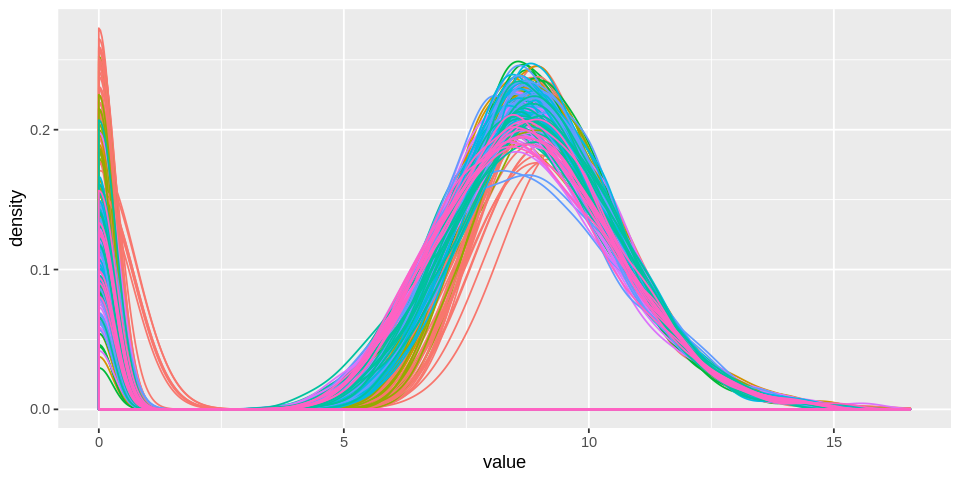

In [594]:
tms_densities[[1]]

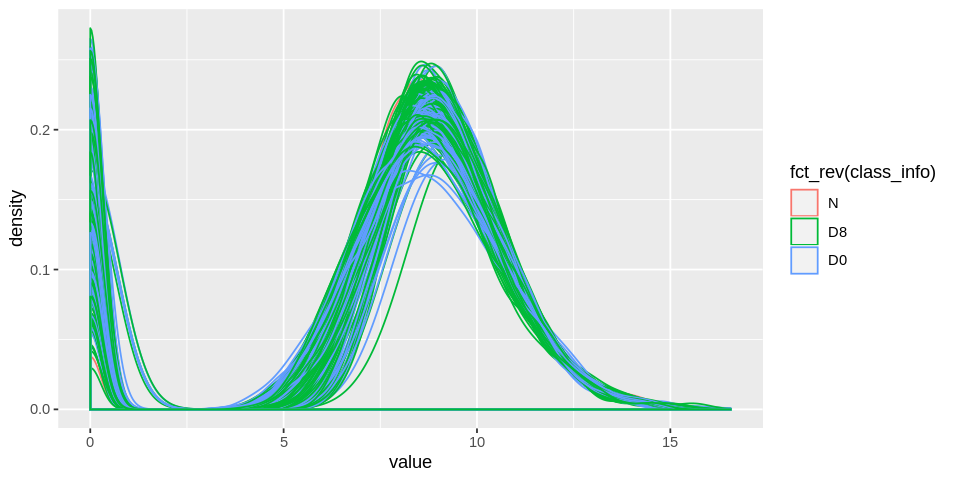

In [595]:
tms_densities[[2]]

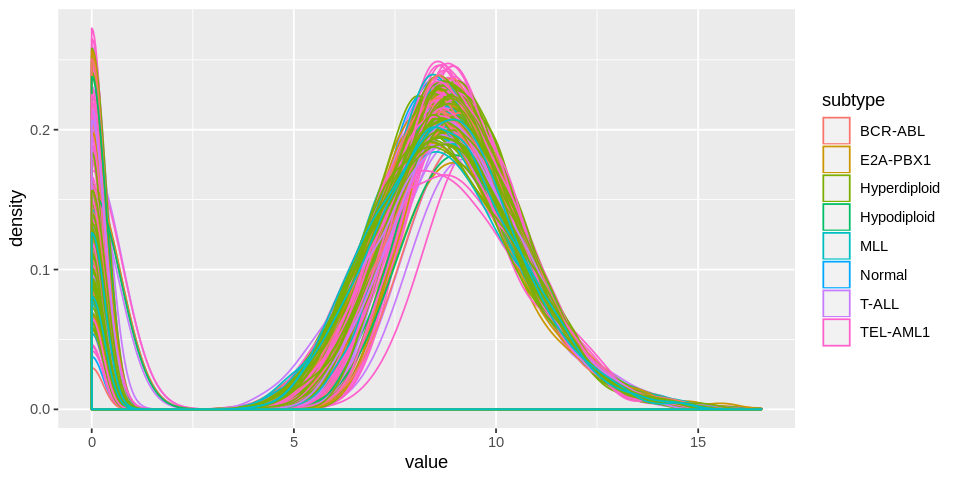

In [596]:
tms_densities[[3]]

In [597]:
raw_densities <- plot_density(data1, metadata_df)

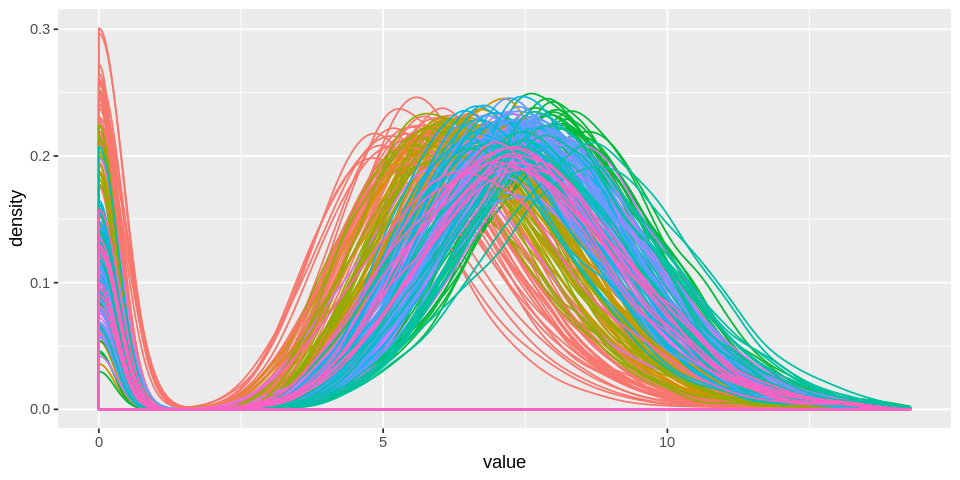

In [598]:
raw_densities[[1]]

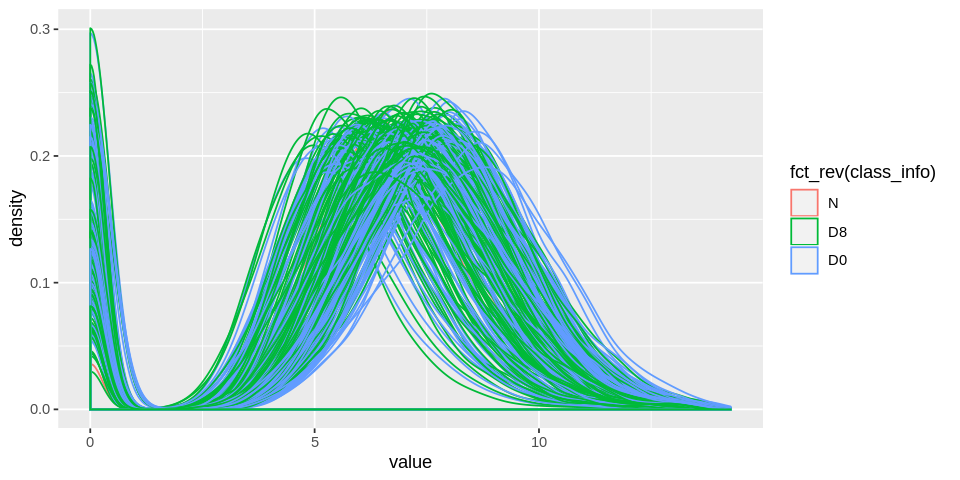

In [599]:
raw_densities[[2]]

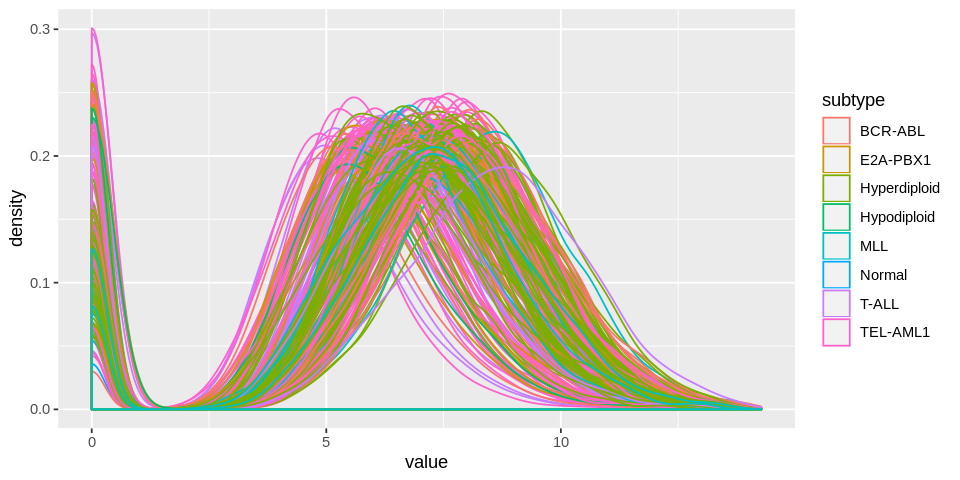

In [600]:
raw_densities[[3]]

In [601]:
wpath1 <- "~/Dropbox/temp/density_raw-batch.pdf"
wpath2 <- "~/Dropbox/temp/density_raw-class.pdf"
wpath3 <- "~/Dropbox/temp/density_raw-subtype.pdf"
wpath4 <- "~/Dropbox/temp/density_tms-batch.pdf"
wpath5 <- "~/Dropbox/temp/density_tms-class.pdf"
wpath6 <- "~/Dropbox/temp/density_tms-subtype.pdf"

ggsave(wpath1, raw_densities[[1]], width = 10, height = 5)
ggsave(wpath2, raw_densities[[2]], width = 10, height = 5)
ggsave(wpath3, raw_densities[[3]], width = 10, height = 5)
ggsave(wpath4, tms_densities[[1]], width = 10, height = 5)
ggsave(wpath5, tms_densities[[2]], width = 10, height = 5)
ggsave(wpath6, tms_densities[[3]], width = 10, height = 5)